In [1]:
# the full tutorial is taken from:
# (1) https://francescopochetti.com/fast-ai-dl2-lesson-9-single-shot-detection-detailed-walkthrough/
# The data Object is adapted from:<
# (2) https://github.com/rohitgeo/singleshotdetector/blob/master/SingleShotDetector%20on%20Pascal.ipynb
# (3) Two improvements may be added here:
#  . implement the reconstruct logic
#  . balance the loss function bbox_loss + clas_loss
#  . reduce layer in the custom head
#  . re-write the det_loss function as a batch processing (remove the loop)

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *

import json, pdb
from matplotlib import patches, patheffects
import numpy as np
# import pandas as pd
from torchvision.models import resnet34

torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark=True

In [5]:
PATH = Path('data/pascal_2007')

In [6]:
PATH.ls()

[PosixPath('data/pascal_2007/tmp'),
 PosixPath('data/pascal_2007/train.json'),
 PosixPath('data/pascal_2007/train'),
 PosixPath('data/pascal_2007/images_trn_val'),
 PosixPath('data/pascal_2007/valid.json'),
 PosixPath('data/pascal_2007/test'),
 PosixPath('data/pascal_2007/test.json'),
 PosixPath('data/pascal_2007/images')]

In [7]:
images_trn, lbl_bbox_trn = get_annotations(PATH / 'train.json')
images_tes, lbl_bbox_tes = get_annotations(PATH / 'test.json')
images_val, lbl_bbox_val = get_annotations(PATH / 'valid.json')

In [8]:
img2bbox_trn = dict(zip(images_trn, lbl_bbox_trn))
img2bbox_tes = dict(zip(images_tes, lbl_bbox_tes))
img2bbox_val = dict(zip(images_val, lbl_bbox_val))

In [9]:
def get_lrg_index(b):    
    bb = np.array(b)    
    inx = np.argmax(np.prod(bb[:, -2:]-bb[:, :2], axis=1))
    return inx

In [10]:
def get_y_func(x):
#     pdb.set_trace()
    if x.name in img2bbox_trn:
        bboxes, classes = img2bbox_trn[x.name]
    else:
        bboxes, classes = img2bbox_val[x.name]        
    
    # extract only large bb   
    inx = get_lrg_index(bboxes)
    
    # need to be a list of objects in order to work correctly
    return [ [bboxes[inx]], [classes[inx]] ] 
         

In [11]:
# check if both training and validation are disjoint
set(images_trn).isdisjoint(images_val)

True

In [12]:
data = (ObjectItemList.from_folder(PATH / 'images_trn_val')
        .split_by_files(images_val)        
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)        
        .databunch(bs=16, collate_fn=bb_pad_collate)        
        .normalize(imagenet_stats)
       )
data

ImageDataBunch;

Train: LabelList (2501 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/pascal_2007/images_trn_val;

Valid: LabelList (2510 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/pascal_2007/images_trn_val;

Test: None

In [13]:
x, y = next(iter(data.train_dl))

CPU times: user 716 ms, sys: 372 ms, total: 1.09 s
Wall time: 1.74 s


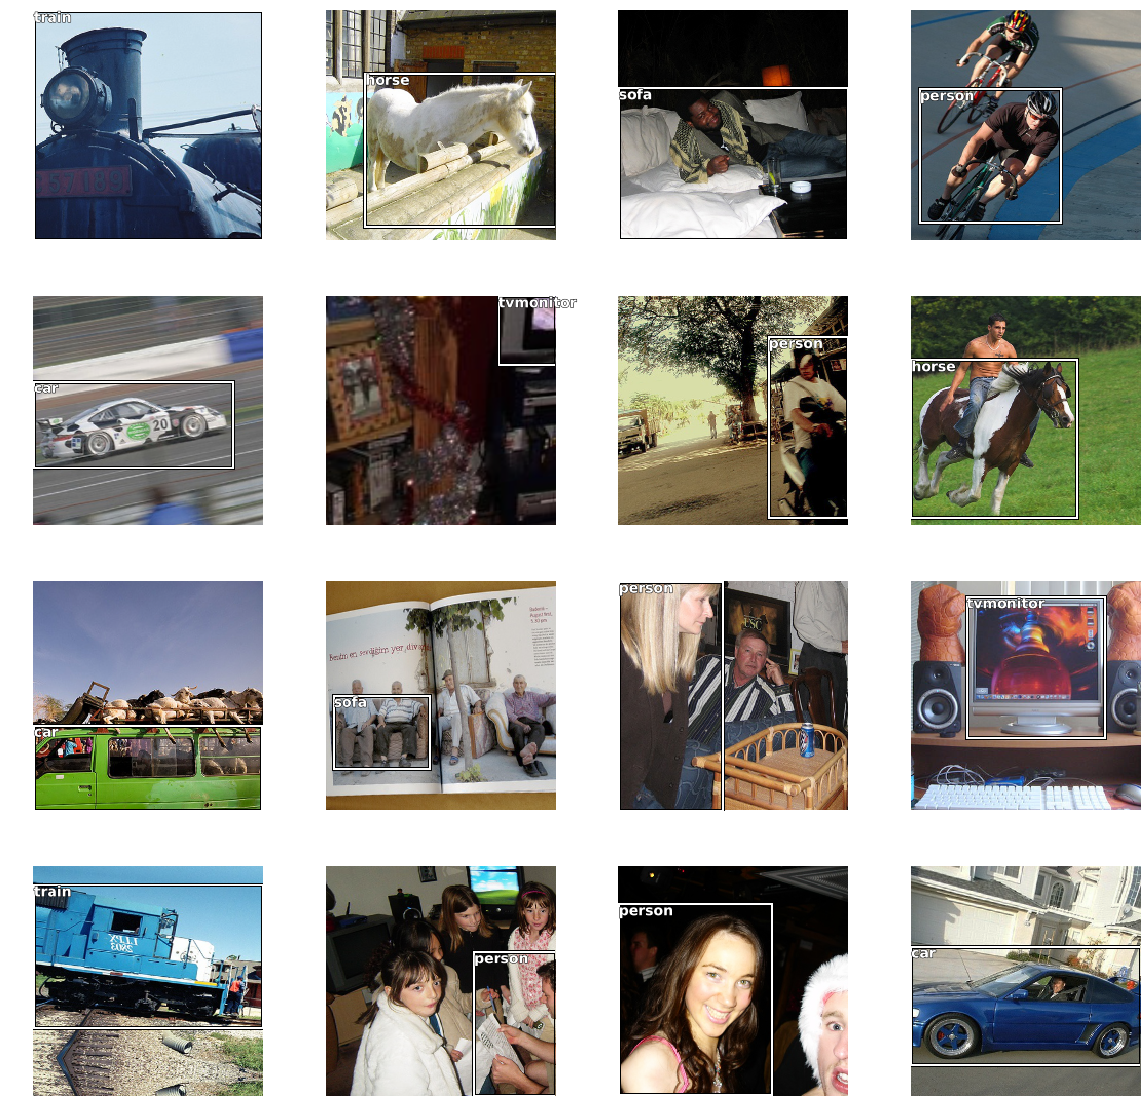

In [14]:
%%time
data.show_batch()

In [15]:
torch.cuda.is_available()

True

In [16]:
# params for ssd head
k = 1
num_class = data.c
print('num_class = ', num_class)
backbone = resnet34
bias = -3.0

num_class =  21


In [17]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + num_class) # 4 BB + 21 classes
)

In [18]:
learner = cnn_learner(data=data, base_arch=backbone, custom_head=head_reg4)

In [37]:
# define loss

def get_target(box, clas):
    box = box.view(-1, 4)
    inx = ((box[:, 2] - box[:, 0]) > 0).nonzero()[:, 0]
    return box[inx], clas[inx]

def normalize(box):
    return (box + 1.) / 2.

# box regression
def det_loss(pred, box_t, clas_t):
#     pdb.set_trace()
    box_loss, clas_loss = 0, 0    
    for i in range(box_t.shape[0]):
        
        # extract predicted bb and predicted class:
        pred_bb, pred_c = pred[i, :4], pred[i, 4:]
        
        # here process one batch each time so:
        pred_c = pred_c[None, :]
        
        # extract target (ground true) bb and target class
#         targ_bb, targ_c = get_target(box_t[i], clas_t[i])
        targ_bb, targ_c = box_t[i], clas_t[i]
        
        # bb is normalized between -1 and 1 for width and height - not sure it's necessary
        # here I undo this
        targ_bb = normalize(targ_bb)
        
        # calculate box regression loss
#         pdb.set_trace()
        box_loss += F.l1_loss(pred_bb, targ_bb)
        
        # calculate cross entropy loss
        if targ_c.nelement() == 0:
            pdb.set_trace()
            
        clas_loss += F.cross_entropy(pred_c, targ_c)
    
    box_loss = box_loss / box_t.shape[0]
    clas_loss = clas_loss / box_t.shape[0]
#     pdb.set_trace()
    
    return box_loss + clas_loss

In [38]:
learner.loss_func = det_loss

In [ ]:
learner.lr_find()n

epoch,train_loss,valid_loss,time


> <ipython-input-37-1c65278fbd70>(14)det_loss()
-> box_loss, clas_loss = 0, 0
(Pdb) l
  9  	    return (box + 1.) / 2.
 10  	
 11  	# box regression
 12  	def det_loss(pred, box_t, clas_t):
 13  	    pdb.set_trace()
 14  ->	    box_loss, clas_loss = 0, 0
 15  	    for i in range(box_t.shape[0]):
 16  	
 17  	        # extract predicted bb and predicted class:
 18  	        pred_bb, pred_c = pred[i, :4], pred[i, 4:]
 19  	
(Pdb) n
> <ipython-input-37-1c65278fbd70>(15)det_loss()
-> for i in range(box_t.shape[0]):
(Pdb) n
> <ipython-input-37-1c65278fbd70>(18)det_loss()
-> pred_bb, pred_c = pred[i, :4], pred[i, 4:]
(Pdb) n
> <ipython-input-37-1c65278fbd70>(21)det_loss()
-> pred_c = pred_c[None, :]
(Pdb) n
> <ipython-input-37-1c65278fbd70>(25)det_loss()
-> targ_bb, targ_c = box_t[i], clas_t[i]
(Pdb) n
> <ipython-input-37-1c65278fbd70>(29)det_loss()
-> targ_bb = normalize(targ_bb)
(Pdb) n
> <ipython-input-37-1c65278fbd70>(33)det_loss()
-> box_loss += F.l1_loss(pred_bb, targ_bb)
(Pdb) l
 28  

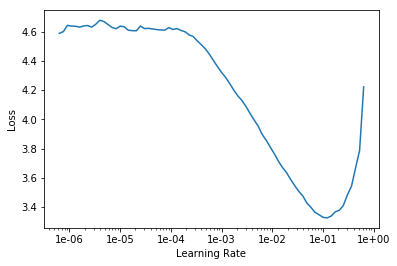

In [22]:
learner.recorder.plot()

In [28]:
lr = 7e-3

In [24]:
learner.fit(epochs=5, lr=lr)

epoch,train_loss,valid_loss,time
0,1.667673,1.299098,00:25
1,1.447676,1.386575,00:25
2,1.314669,1.806396,00:25
3,1.258852,1.318754,00:25
4,1.320231,1.470613,00:25


In [25]:
learner.save('head_reg4')

In [26]:
learner.freeze_to(-2)

In [29]:
lrs = np.array([lr/100, lr/10, lr])

In [30]:
learner.lr_find(lrs/1000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


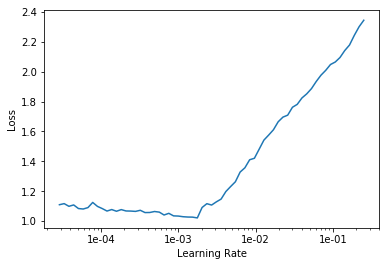

In [31]:
learner.recorder.plot()

In [33]:
learner.fit(epochs=5, lr=lrs/5)

epoch,train_loss,valid_loss,time
0,1.187810,1.169581,00:30
1,1.046753,2.846469,00:29
2,0.973646,2.760145,00:30
3,0.885930,1.248745,00:29
4,0.910052,1.473909,00:30


In [34]:
learner.save('head_reg4_1')

In [35]:
learner.load('head_reg4_1')

Learner(data=ImageDataBunch;

Train: LabelList (2501 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/pascal_2007/images_trn_val;

Valid: LabelList (2510 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: data/pascal_2007/images_trn_val;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): 

In [36]:
learner.unfreeze()

In [37]:
learner.fit(epochs=10, lr=lrs/10)

epoch,train_loss,valid_loss,time
0,0.691038,2.199453,00:33
1,0.599093,3.242476,00:32
2,0.554249,1.252398,00:32
3,0.477260,2.027056,00:32
4,0.465390,1.700013,00:32
5,0.438448,1.642424,00:32
6,0.433228,3.082110,00:32
7,0.388339,1.933759,00:32
8,0.359752,1.388887,00:32
9,0.361465,2.187876,00:32


In [38]:
learner.save('head_reg4_2')

In [21]:
learner.load('head_reg4_2');

In [22]:
from matplotlib import pyplot as plt
from matplotlib import patches

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a):     
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

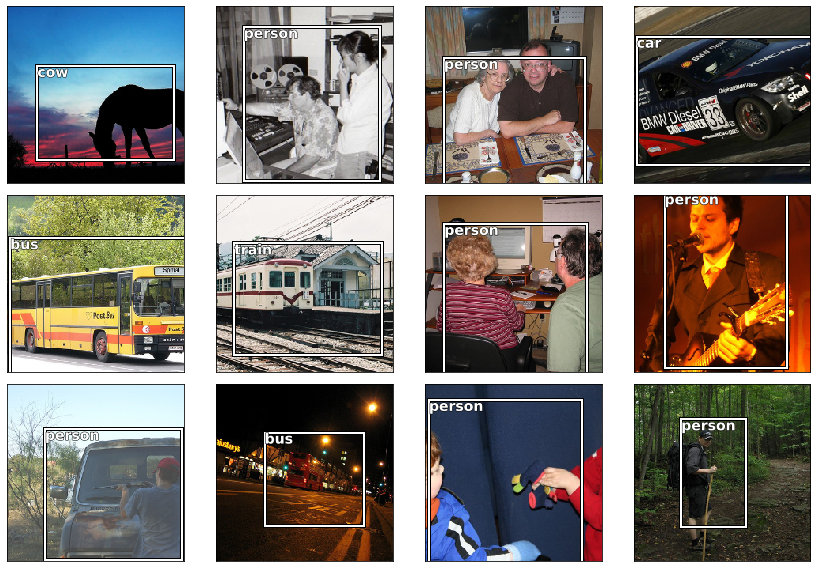

In [36]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    i += 11*12
    # image
    item = learner.data.valid_ds[i][0]
    
    # target
    t = learner.data.valid_ds[i][1].data
    
    # run batch of size one
    batch = learner.data.one_item(item)
    res = learner.pred_batch(batch=batch)
    raw_pred,x = grab_idx(res,0,batch_first=True),batch[0]
    norm = getattr(learner.data,'norm',False)
    if norm:    
        x = learner.data.denorm(x)
        if norm.keywords.get('do_y',False): raw_pred = learner.data.denorm(raw_pred)
    
    ds = learner.data.single_ds
    pred = ds.y.analyze_pred(raw_pred)
    pred_bb = pred[:4]
    pred_cl = pred[4:]
    
    # convert from pytorch to numpy
    img_np = image2np(item.data * 255)
    
    # class
    c = np.argmax(pred_cl.numpy())
    
    # bb
    b = bb2hw(pred_bb.numpy()*224)    
    
    # plot
    ax = show_img(np.uint8(img_np), ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], learner.data.classes[c])
    
plt.tight_layout()